In [1]:
import json
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

/home/superbench/miniconda3/envs/rjy-dpo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# 假设你已经有了一个tokenizer对象
# 你可以从Hugging Face的模型库中获取它，例如：
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_name_or_path = '/mnt/rjy_cache/superbench/my_model/Llama-2-13b-chat-hf'
print(f'Loading tokenizer {tokenizer_name_or_path}')
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name_or_path, cache_dir='/mnt/rjy_cache/superbench')

Loading tokenizer /mnt/rjy_cache/superbench/my_model/Llama-2-13b-chat-hf


Loading tokenizer /mnt/rjy_cache/superbench/my_model/Llama-2-13b-chat-hf


Average Token Length: 1555.7834549878346
Maximum Token Length: 3160
Minimum Token Length: 1120


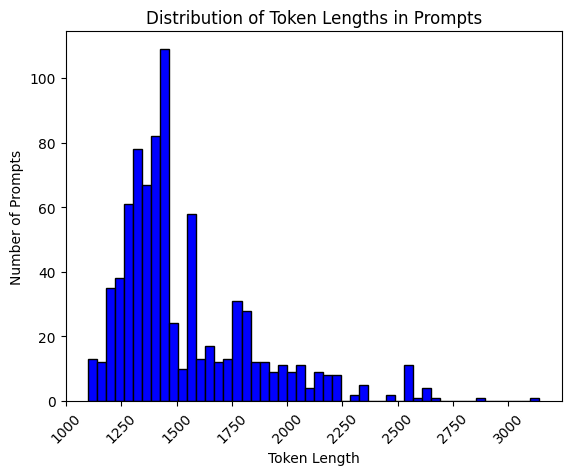

In [3]:


# 加载数据集（这里假设你的数据集是一个JSON文件）
data_no_exaple_path = '/home/superbench/jiyuanren/android_dataset/dataset_dpo_divide_prompt_no_samples.json'
with open(data_no_exaple_path, 'r', encoding='utf-8') as f:
    dataset_no_example = json.load(f)

# 假设dataset是一个list[dict]，并且你已经有了tokenizer
prompt_lengths_no_example = []

for prompt in [item['prompt'] for item in dataset_no_example]:
    # 使用tokenizer对prompt进行分词
    tokens = tokenizer.tokenize(prompt)
    # 计算token的数量
    token_length = len(tokens)
    # 将长度添加到列表中
    prompt_lengths_no_example.append(token_length)

average_length = sum(prompt_lengths_no_example) / len(prompt_lengths_no_example)
max_length = max(prompt_lengths_no_example)
min_length = min(prompt_lengths_no_example)

# 打印统计结果
print(f"Average Token Length: {average_length}")
print(f"Maximum Token Length: {max_length}")
print(f"Minimum Token Length: {min_length}")
# 统计长度分布
plt.hist(prompt_lengths_no_example, bins=50, align='left', color='blue', edgecolor='black')

# 绘制分布图
plt.xlabel('Token Length')
plt.ylabel('Number of Prompts')
plt.title('Distribution of Token Lengths in Prompts')
plt.xticks(rotation=45)  # 如果x轴标签太长，可以旋转以便阅读
plt.show()

# 如果你想要保存这个图，可以使用以下代码
# plt.savefig('prompt_token_length_distribution.png')

718


Average Token Length: 2443.649025069638
Maximum Token Length: 4025
Minimum Token Length: 1990


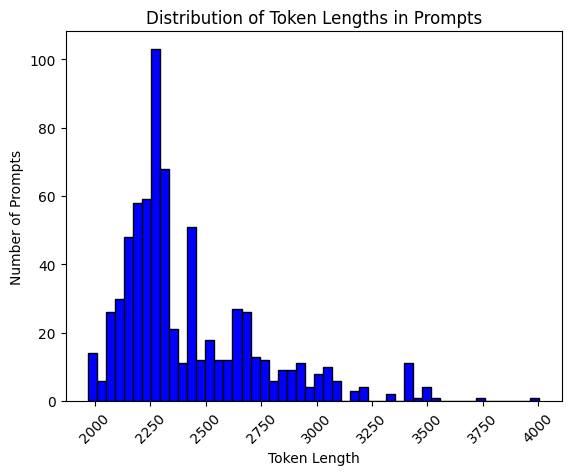

In [8]:
data_with_exaple_path = '/home/superbench/jiyuanren/android_dataset/dataset_dpo_rejected_with_langchain_dedupli.json'
with open(data_with_exaple_path, 'r', encoding='utf-8') as f:
    dataset_with_example = json.load(f)

print(len(dataset_with_example))
# 假设dataset是一个list[dict]，并且你已经有了tokenizer
prompt_lengths_with_example = []

for item in dataset_with_example:
    prompt = ''.join(item['prompt'])
    # 使用tokenizer对prompt进行分词
    tokens = tokenizer.tokenize(prompt)
    # 计算token的数量
    token_length = len(tokens)
    # 将长度添加到列表中
    prompt_lengths_with_example.append(token_length)

average_length = sum(prompt_lengths_with_example) / len(prompt_lengths_with_example)
max_length = max(prompt_lengths_with_example)
min_length = min(prompt_lengths_with_example)

# 打印统计结果
print(f"Average Token Length: {average_length}")
print(f"Maximum Token Length: {max_length}")
print(f"Minimum Token Length: {min_length}")
# 统计长度分布
plt.hist(prompt_lengths_with_example, bins=50, align='left', color='blue', edgecolor='black')

# 绘制分布图
plt.xlabel('Token Length')
plt.ylabel('Number of Prompts')
plt.title('Distribution of Token Lengths in Prompts')
plt.xticks(rotation=45)  # 如果x轴标签太长，可以旋转以便阅读
plt.show()

In [28]:
def get_date_in_prompt(prompt):
    # 定义正则表达式模式，匹配月份、日期、年份和星期
    # date_pattern = r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+(\d{2})\s+(\d{4})\s+(Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)'
    date_pattern = r"Today is (.*?),"
    # 使用re.search()查找匹配的日期
    match = re.search(date_pattern, prompt)

    if match:
        # 提取匹配的整个日期字符串
        date_full_string = match.group(1)  # 获取第一个括号内匹配的内容

        # 分割字符串以获取日期部分
        # 假设日期部分总是以月份开始，后跟空格、日期、空格、年份
        date_parts = date_full_string.split()
        date_string = ' '.join(date_parts[0:4])  # 通常日期部分是前三个元素
    else:
        print("No matching date found.")
        date_string = None
    return date_string

## 3 缩短system prompt

In [4]:
new_system_prompt_template = "You are an autonomous agent for mobile phone tasks, from simple queries to complex instructions. \nKey info includes:\n- User's objective: The task to complete.\n- Installed APPs: APPs available for operation.\n- Current Observation: Simplified, structured phone view.\n- Previous action and Observation: To track progress.\n\nSolve tasks with Observation, Thought, Action cycles:\nThoughts reason about the situation; end with an Action:\n1. APP Actions: Start with #start [app_name]#. Limited to the following APPs:\n> Firefox: Firefox web browser. You can search for any news, events and knowledge here.\n> Camera: Native Android camera APP, useful for taking photos and recording videos.\n> Gmail: Connect, create and collaborate with Gmail, part of Google Workspace.\n> Contacts: Back up your contacts & access them anywhere.\n> Clock: Check the time at different timezone and set alarm.\n> Google Maps: Real-time GPS navigation & local suggestions for food, events & activities.\n> Google Drive: a safe place to back up and access all your files from any device.\n> Messages: Simple, helpful messaging by Google.\n> Weather: Get weather information.\n> YouTube: Enjoy your favourite videos and channels with the official YouTube app.\n> Settings: The phone settings. You can check and modify phone settings here.\n> Photos: The home for all your photos and videos, automatically organized and easy to share.\n\n2. UI Actions: Interact with elements via #click [id]#, #long_click [id]#, #set_text [id] [text]#.\n3. System Actions: Navigate with #swipe_up#, #swipe_down#, #swipe_left#, #swipe_right#, #press_back#, #press_enter#.\n4. Completion: #finish [answer]# when task is done or if impossible, use \\N/A\.\nFollow rules for success: Issue one action per cycle, format actions correctly, and use the current date {current_date} for task relevance.\n"

In [30]:
# 替换原来的prompt，看token是否缩短
import re
data_with_exaple_path = '/home/superbench/jiyuanren/android_dataset/dataset_dpo_rejected_with_langchain_dedupli.json'
with open(data_with_exaple_path, 'r', encoding='utf-8') as f:
    dataset_with_example = json.load(f)

print(len(dataset_with_example))


718


In [29]:
temp_data_str = get_date_in_prompt(dataset_with_example[600]['prompt'][0])
print(temp_data_str)

Dec 13 2023 Thursday


In [10]:
print(new_system_prompt_template.replace('{current_date}', temp_data_str))

You are an autonomous agent for mobile phone tasks, from simple queries to complex instructions. 
Key info includes:
- User's objective: The task to complete.
- Installed APPs: APPs available for operation.
- Current Observation: Simplified, structured phone view.
- Previous action and Observation: To track progress.

Solve tasks with Observation, Thought, Action cycles:
Thoughts reason about the situation; end with an Action:
1. APP Actions: Start with #start [app_name]#. Limited to the following APPs:
> Firefox: Firefox web browser. You can search for any news, events and knowledge here.
> Camera: Native Android camera APP, useful for taking photos and recording videos.
> Gmail: Connect, create and collaborate with Gmail, part of Google Workspace.
> Contacts: Back up your contacts & access them anywhere.
> Clock: Check the time at different timezone and set alarm.
> Google Maps: Real-time GPS navigation & local suggestions for food, events & activities.
> Google Drive: a safe place t

Average Token Length: 1067.649025069638
Maximum Token Length: 2649
Minimum Token Length: 614


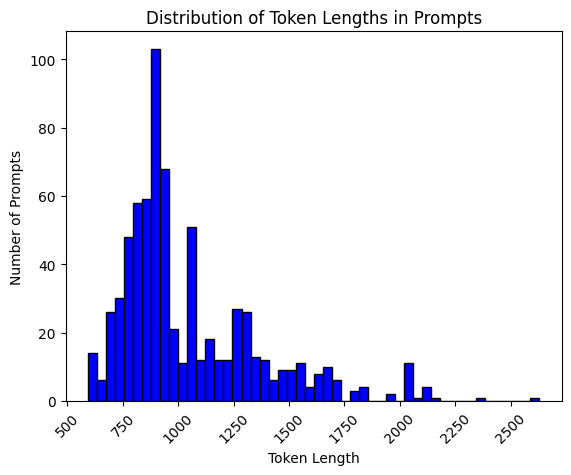

In [31]:
# 假设dataset是一个list[dict]，并且你已经有了tokenizer
prompt_lengths_new = []

for item in dataset_with_example:
    # 从prompt中提取日期
    date_str = get_date_in_prompt(item['prompt'][0])
    # 使用日期替换{current_date}
    new_system_prompt = new_system_prompt_template.replace('{current_date}', date_str)
    item['prompt'][0] = new_system_prompt
    prompt = ''.join([new_system_prompt, item['prompt'][5]])
    # 使用tokenizer对prompt进行分词
    tokens = tokenizer.tokenize(prompt)
    # 计算token的数量
    token_length = len(tokens)
    # 将长度添加到列表中
    prompt_lengths_new.append(token_length)

average_length = sum(prompt_lengths_new) / len(prompt_lengths_new)
max_length = max(prompt_lengths_new)
min_length = min(prompt_lengths_new)

# 打印统计结果
print(f"Average Token Length: {average_length}")
print(f"Maximum Token Length: {max_length}")
print(f"Minimum Token Length: {min_length}")
# 统计长度分布
plt.hist(prompt_lengths_new, bins=50, align='left', color='blue', edgecolor='black')

# 绘制分布图
plt.xlabel('Token Length')
plt.ylabel('Number of Prompts')
plt.title('Distribution of Token Lengths in Prompts')
plt.xticks(rotation=45)  # 如果x轴标签太长，可以旋转以便阅读
plt.show()

save_path = '/home/superbench/jiyuanren/android_dataset/dataset_dpo_deduplication_new_promopt.json'
with open(save_path, 'w') as file:
    json.dump(dataset_with_example, file)

## 4 在3的基础上，对prompt+response超过1700的prompt去掉app描述

In [32]:
shorten_system_prompt_template = "You are an autonomous agent for mobile phone tasks, from simple queries to complex instructions. \nKey info includes:\n- User's objective: The task to complete.\n- Installed APPs: APPs available for operation.\n- Current Observation: Simplified, structured phone view.\n- Previous action and Observation: To track progress.\n\nSolve tasks with Observation, Thought, Action cycles:\nThoughts reason about the situation; end with an Action:\n1. APP Actions: Start with #start [app_name]#. Limited to the following APPs:\n> Firefox\n> Camera\n> Gmail\n> Contacts\n> Clock\n> Google Maps\n> Google Drive\n> Messages\n> Weather\n> YouTube\n> Settings\n> Photos\n\n2. UI Actions: Interact with elements via #click [id]#, #long_click [id]#, #set_text [id] [text]#.\n3. System Actions: Navigate with #swipe_up#, #swipe_down#, #swipe_left#, #swipe_right#, #press_back#, #press_enter#.\n4. Completion: #finish [answer]# when task is done or if impossible, use \\N/A\.\nFollow rules for success: Issue one action per cycle, format actions correctly, and use the current date {current_date} for task relevance.\n"

In [34]:
len_new_system_prompt_template = len(tokenizer.tokenize(new_system_prompt_template))
len_shorten_system_prompt_template = len(tokenizer.tokenize(shorten_system_prompt_template))
delta_token_length = len_new_system_prompt_template - len_shorten_system_prompt_template
print(f"Length of original system prompt: {len_new_system_prompt_template}")
print(f"Length of shortened system prompt: {len_shorten_system_prompt_template}")
print(f"Delta token length: {delta_token_length}")

Length of original system prompt: 488
Length of shortened system prompt: 324
Delta token length: 164


In [44]:
data_with_exaple_path = '/home/superbench/jiyuanren/android_dataset/dataset_dpo_rejected_with_langchain_dedupli.json'
with open(data_with_exaple_path, 'r', encoding='utf-8') as f:
    dataset_with_example = json.load(f)

print(len(dataset_with_example))

718


In [45]:
token_len_limit = 1800
# 假设dataset是一个list[dict]，并且你已经有了tokenizer
prompt_lengths_new = []
prompt_responses_length = []

for item in dataset_with_example:
    # 从prompt中提取日期
    date_str = get_date_in_prompt(item['prompt'][0])
    # 使用日期替换{current_date}
    new_system_prompt = new_system_prompt_template.replace('{current_date}', date_str)
    prompt = ''.join([new_system_prompt, item['prompt'][5]])
    len_prompt = len(tokenizer.tokenize(prompt))
    len_chosen = len(tokenizer.tokenize(item['chosen']))
    len_rejected = len(tokenizer.tokenize(item['rejected']))
    max_token_length = max(len_prompt+len_chosen , len_prompt+len_rejected)
    if max_token_length > token_len_limit:
        shorten_system_prompt = shorten_system_prompt_template.replace('{current_date}', date_str)
        item['prompt'][0] = shorten_system_prompt
        prompt = ''.join([shorten_system_prompt, item['prompt'][5]])
        token_length = max_token_length - delta_token_length
    else:
        token_length = max_token_length
        item['prompt'][0] = new_system_prompt
    # 将长度添加到列表中
    prompt_lengths_new.append(len(tokenizer.tokenize(prompt)))
    prompt_responses_length.append(token_length)



Average Prompt Token Length: 1059.4261838440111
Maximum Prompt Token Length: 2485
Minimum Prompt Token Length: 614


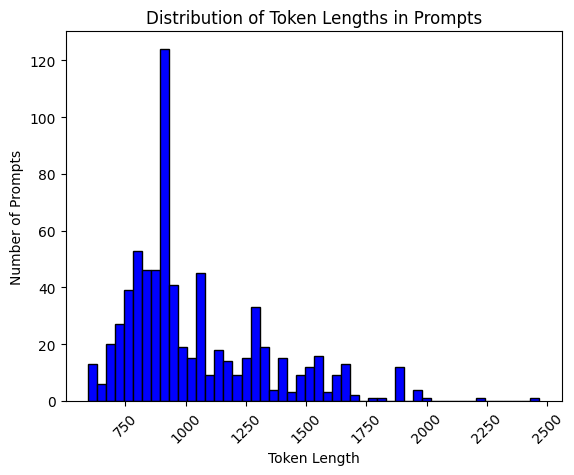

In [41]:
average_length = sum(prompt_lengths_new) / len(prompt_lengths_new)
max_length = max(prompt_lengths_new)
min_length = min(prompt_lengths_new)

# 打印统计结果
print(f"Average Prompt Token Length: {average_length}")
print(f"Maximum Prompt Token Length: {max_length}")
print(f"Minimum Prompt Token Length: {min_length}")
# 统计长度分布
plt.hist(prompt_lengths_new, bins=50, align='left', color='blue', edgecolor='black')

# 绘制分布图
plt.xlabel('Token Length')
plt.ylabel('Number of Prompts')
plt.title('Distribution of Token Lengths in Prompts')
plt.xticks(rotation=45)  # 如果x轴标签太长，可以旋转以便阅读
plt.show()


Average Token Length: 1137.8300835654595
Maximum Token Length: 2586
Minimum Token Length: 673


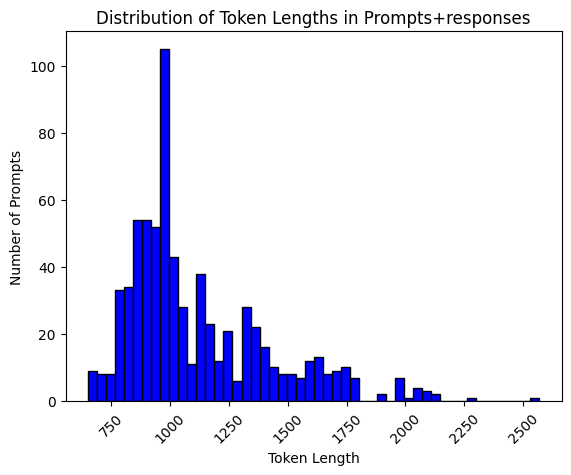

In [42]:
# ------with response
average_length = sum(prompt_responses_length) / len(prompt_responses_length)
max_length = max(prompt_responses_length)
min_length = min(prompt_responses_length)

# 打印统计结果
print(f"Average Token Length: {average_length}")
print(f"Maximum Token Length: {max_length}")
print(f"Minimum Token Length: {min_length}")
# 统计长度分布
plt.hist(prompt_responses_length, bins=50, align='left', color='blue', edgecolor='black')

# 绘制分布图
plt.xlabel('Token Length')
plt.ylabel('Number of Prompts')
plt.title('Distribution of Token Lengths in Prompts+responses')
plt.xticks(rotation=45)  # 如果x轴标签太长，可以旋转以便阅读
plt.show()


In [46]:
save_path = '/home/superbench/jiyuanren/android_dataset/dataset_dpo_deduplication_len1800_promopt.json'
with open(save_path, 'w') as file:
    json.dump(dataset_with_example, file)